## 1. Import Libraries

In [12]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.19.0


In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


In [14]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


In [15]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims)
    img = np.array(img, dtype=np.float32)
    return img

In [16]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.04 s, sys: 720 ms, total: 1.76 s
Wall time: 2.14 s


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- 1. Define input shape ---
INPUT_SHAPE = (32, 32, 3)   # same as your VGG example

# --- 2. Load DenseNet base ---
densenet_base = tf.keras.applications.DenseNet121(
    weights='imagenet',      # load pretrained ImageNet weights
    include_top=False,       # exclude final classifier
    input_shape=INPUT_SHAPE
)

# --- 3. Freeze base model initially ---
densenet_base.trainable = False

# --- 4. Build full model ---
model = models.Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),          # better than Flatten for CNNs
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')    # change 10 -> your #classes
])

# --- 5. Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1, 1, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,302,474 (27.86 MB)

 Trainable params: 264,970 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
EPOCHS = 5 #100 full passes through the dataset
train_images_3ch_scaled = train_images_3ch / 255. #Raw pixel values range from 0–255.
#Dividing by 255 normalizes them to 0–1, which speeds up training and stabilizes gradients.#
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
restore_best_weights=True,
verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
batch_size=32,
callbacks=[es_callback],
validation_split=0.1, epochs=EPOCHS,
verbose=1)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 262s 144ms/step - accuracy: 0.7138 - loss: 0.8351 - val_accuracy: 0.8338 - val_loss: 0.4617
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 270s 149ms/step - accuracy: 0.8184 - loss: 0.4909 - val_accuracy: 0.8498 - val_loss: 0.4129
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 254s 150ms/step - accuracy: 0.8318 - loss: 0.4667 - val_accuracy: 0.8510 - val_loss: 0.3998
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 249s 148ms/step - accuracy: 0.8383 - loss: 0.4445 - val_accuracy: 0.8563 - val_loss: 0.3916
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 249s 147ms/step - accuracy: 0.8421 - loss: 0.4233 - val_accuracy: 0.8622 - val_loss: 0.3839
Restoring model weights from the end of the best epoch: 5.


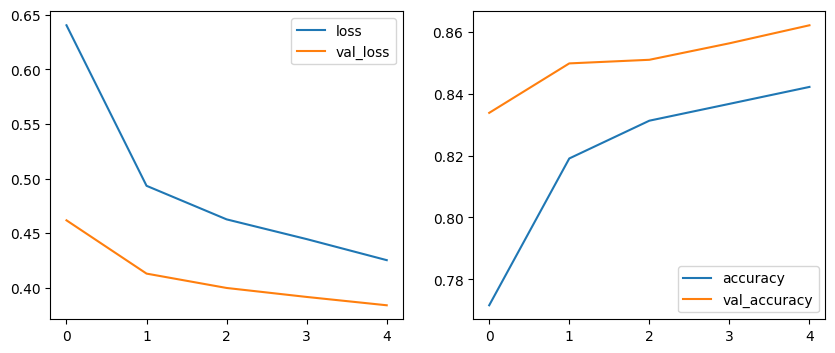

In [19]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [20]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step


array([[3.31686039e-08, 1.99938244e-09, 3.86308763e-09, 1.22502701e-08,
        3.37210189e-08, 3.91732377e-04, 4.97357064e-07, 2.31829286e-02,
        8.52077847e-06, 9.76416230e-01],
       [1.66706828e-04, 5.46778134e-09, 9.99281406e-01, 1.86368152e-06,
        2.81146262e-04, 2.42955799e-14, 2.68766395e-04, 7.09800862e-15,
        1.02999785e-07, 1.13209282e-14],
       [9.73666568e-13, 9.99999821e-01, 8.20341624e-12, 9.17334972e-08,
        7.05134562e-11, 2.34576196e-17, 2.61934528e-12, 3.20564980e-19,
        8.38890936e-12, 7.80611601e-17],
       [4.15066981e-10, 9.99896824e-01, 3.99415806e-10, 1.02945502e-04,
        5.55368587e-08, 9.89806280e-15, 6.46525633e-09, 1.19452144e-15,
        4.51976928e-11, 1.20998033e-13],
       [8.43980610e-02, 4.43873927e-04, 6.48645610e-02, 1.65235236e-01,
        1.05473541e-01, 1.05790168e-05, 5.76603830e-01, 4.84253042e-06,
        2.93087447e-03, 3.45144836e-05]], dtype=float32)

In [21]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.81      0.78      0.80      1000
       Dress       0.80      0.85      0.82      1000
        Coat       0.71      0.77      0.74      1000
      Sandal       0.96      0.94      0.95      1000
       Shirt       0.66      0.59      0.62      1000
     Sneaker       0.89      0.97      0.93      1000
         Bag       0.96      0.96      0.96      1000
  Ankle boot       0.98      0.92      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,816,2,15,53,7,0,96,0,11,0
Trouser,1,957,0,30,4,0,5,0,3,0
Pullover,14,0,781,14,113,0,73,0,5,0
Dress,23,18,10,849,49,0,44,1,6,0
Coat,5,0,77,70,773,0,73,0,2,0
Sandal,0,0,0,0,0,945,0,48,0,7
Shirt,151,2,71,40,138,0,586,0,11,1
Sneaker,0,0,0,0,0,16,0,972,0,12
Bag,2,0,5,4,3,9,13,1,960,3
Ankle boot,0,0,0,1,0,12,0,66,5,916


In [23]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]
